# Final Project: Airbnb Case Study in New York City #
<br>
<br>

<div class="inline-block"> <img src= "http://www.hotelnewsnow.com/Media/Default/Legacy//FeatureImages/airbnb_newyork.jpg"
style="width:900px;"/> </div> 

**Author: Nan Jiang** <br> **Email: [nancy.jiang@nyu.edu](nancy.jiang@nyu.edu)**

This project will study Airbnb listings within New York City by density, room type and pricing. Due to its enormous traffic flow and skyrocketing rental fees, New York City accommocates a huge airbnb market across its 5 distinct boroughs. This project will group current Airbnb listings by boroughs, neibourhoods and room types and visualize the outstanding difference in availability and prices.

The project will have the following three sections:

- **Listing Density by Neighbourhood:** Questions such as "How many listings are there in NYC, in each borough and in each neibourhood?" will be analyzed and visualized with charts and maps. 

- **Price Level Analysis:** I will start off with calculating the average price level of listings in each borough. To address the differences in borough size, proportion of different room types, I will further break down average price in each borough by neibourhood and room type. Bar charts and pie charts will be utilized to visualize key takeaways and answer questions such as "What is the cheapest/most expensive combination of boroughs and room type to stay at?"

- **Airbnb v. Hotels Comparison:** I will introduce Yelp API and inquire price levels of all hotels across New York City. Similar to what I did in Section 1 and 2, I will produce a density map and calculate the average price level, indicated by the number of "$" signs, for Yelp's hotel data to benchmark against what we have derived in previous two sections. 

## Data Report

The key data of the project include [NYC Airbnb Listing Dataset](http://data.insideairbnb.com/united-states/ny/new-york-city/2018-03-04/visualisations/listings.csv) and [Yelp's API](https://api.yelp.com/v3/businesses/{id). The dataset is a thorough collection of data on prices, whereabouts and room type of each listing. The latter provides access to price levels of some selection of hotels in the neighbourhood, which gives a rough sense how airbnb prices would compare across. Details of this dataset are described below in the data report.

**Overview:** The data behind my project comes from the [Inside Airbnb](http://insideairbnb.com/). It is an independent, non-commercial set of data that aggregated all publicly avaliable information of Airbnb listings across the world. Their [NYC Airbnb Listing Dataset](http://data.insideairbnb.com/united-states/ny/new-york-city/2018-03-04/visualisations/listings.csv) provides access to key metrics and information including, prices, location, room type, number of reviews and dates of availability for each listing.

**Important Variables:** The key series of variables I will be focusing on in this project include the prices and location details of the listings. Through Yelp's API, I will also analyze average hotel prices within different neighborhoods. 

** Geography:** The geography that I will work with is New York City. However, the same analysis could be easily applied to other cities as well.


## My Packages

In the analysis below, I will use the following packages:
- **Pandas** will be my core tool to import, manipulate, merge and analyze data
- **Matplotlib** will help me visualize results in plots
- **numpy** allow me to perform complicated mathimatical operations and transformations on my dataset 
- **geopandas** allow me to map out key insights extracted from the dataset 

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import geopandas as gpd
import fiona
import requests
import zipfile
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

## Data Introduction ##

Below I read in and organize the dataset for later convenience. Specifically, I first eliminate insubstantial entries and extract certain columns under different dataframes in preparation for later analyses.

In [106]:
url = "http://data.insideairbnb.com/united-states/ny/new-york-city/2018-03-04/visualisations/listings.csv"
airbnb = pd.read_csv(url)

To clean up the dataset, I first removed all listings whose price is less than 10 USD, as according to [Airbnb New York City](https://www.airbnb.com/s/New-York-City--NY--United-States/homes?refinement_paths%5B%5D=%2Fhomes&allow_override%5B%5D=&query=New%20York%20City%2C%20NY%2C%20United%20States), 10 USD is the minimum starting price. I then capitalize the first letter of all column names. 

In [107]:
airbnb["price"] = pd.to_numeric(airbnb["price"])
airbnb = airbnb[airbnb.price >= 10]

airbnb.columns = [var.capitalize() for var in airbnb.columns]  

Below I assign certain columns into theme dataframes for later reference.

In [108]:
listing = ['Id', 'Neighbourhood_group', 'Neighbourhood', 'Room_type', 'Price'] 
ablist = airbnb[listing]

location = ['Id', 'Longitude', 'Latitude']
abloc = airbnb[location]

## Listing Density

### How many Airbnb listings are there in New York City currently?

The large dataset on hand begs the first question: How many Airbnb listings are there in New York City currently? This question could be answered simply through the code below, which tells us the row number of rows and columns in dataframe ablist.

In [109]:
ablist.shape

(48809, 5)

As each listing is represented by a unique ID and each row includes an ID, we can conclude that according to this dataset, there are currently 48,809 listings in New York City, after removing the ineligible ones. 

### How many Airbnb listings are there in each borough? ####

It would be nice to breakdown the listings by boroughs to get a rough idea of their distribution. This could be achieved through command "groupby" and method "count":

In [110]:
ablist_num = ablist.groupby(["Neighbourhood_group"])["Id"].count()
ablist_num = pd.DataFrame(ablist_num)
ablist_num.columns = ["Listing"] 
display(ablist_num)

,Listing
Neighbourhood_group,
Bronx,876
Brooklyn,20426
Manhattan,22139
Queens,5073
Staten Island,295


Not surprisingly, Manhattan, which is home to headquarters of big businesses and most schools in New York City, has the largest number of listings. Brooklyn, on the other hand, home to most residential areas followed tightly. It is, however, a little bit surprising to see the relatively big drop off in Queens, Bronx and Staten Island. While they are less tourist friendly, distant from most landmarks, it is still shocking to observe roughly 4 times, 30 times and 70 times difference compared with Manhattan and Brooklyn.

To account for the fact that demographics is rather different across boroughs, I pulled in New York City's 2017 estimated population statistics from [City Population](https://www.citypopulation.de/php/usa-newyorkcity.php) to normalize listings in each borough.

In [111]:
nycpop = pd.DataFrame({"Bronx": [1471.160], "Brooklyn": [2648.771],
                       "Manhattan": [1664.272],"Queens": [2358.582],
                       "Staten Island": [479.458],})
nycpop = nycpop.T
nycpop.columns = ["Thousand_people"]
display(nycpop)

,Thousand_people
Bronx,1471.160
Brooklyn,2648.771
Manhattan,1664.272
Queens,2358.582
Staten Island,479.458


Through column calculations and assigning new column, we obtained the new dataframe ablist_num below, that shows the number of listings per thousand people.  

In [112]:
ablist_num["Listing/k_ppl"] = ablist_num["Listing"]/nycpop["Thousand_people"]
display(ablist_num)

,Listing,Listing/k_ppl
Neighbourhood_group,,
Bronx,876,0.595448
Brooklyn,20426,7.711501
Manhattan,22139,13.302513
Queens,5073,2.150869
Staten Island,295,0.615278


This adjustment considerably increased the difference between Brooklyn and Manhattan, which to some extent shows that the large number of listings in Brooklyn is due to its larger population and borough size. Moreover, Bronx and Staten Island converged under this measure, both of which significantly reduce the dispartiy to Manhanttan. Noticeably, Staten Island surpassed Bronx in number of listings per thousand of people. 

The graph below illustrates this comparison of listings across boroughs.

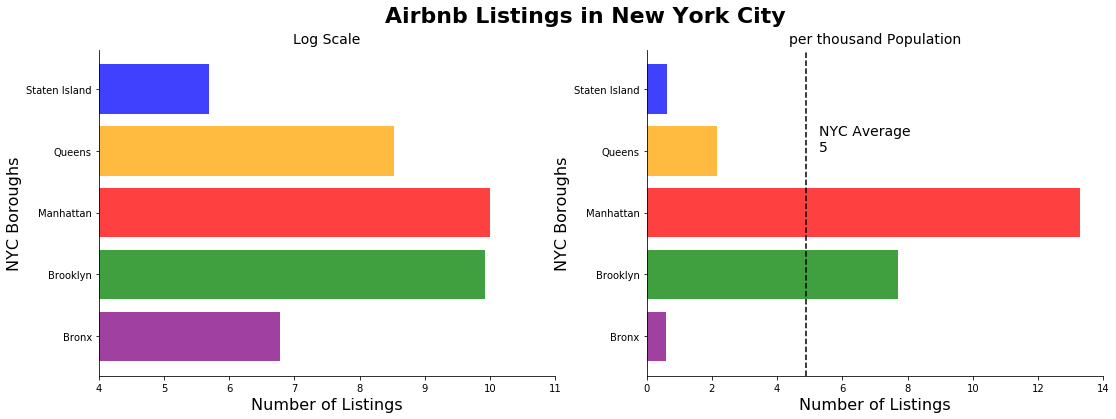

In [113]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))

my_colors = ['purple', 'green', 'red', 'orange', 'blue']

ax[0].barh(ablist_num.index.tolist(), np.log(ablist_num["Listing"]), alpha = 0.75, color = my_colors)
ax[1].barh(ablist_num.index.tolist(), ablist_num["Listing/k_ppl"], alpha = 0.75, color = my_colors)

fig.suptitle("Airbnb Listings in New York City", fontsize = 22, fontweight = "bold")

ax[0].set_title("Log Scale", fontsize = 14) 
ax[1].set_title("per thousand Population", fontsize = 14)

ax[0].set_xlim(4,11)
ax[1].set_xlim(0,14)

ax[0].set_xlabel("Number of Listings", fontsize = 16)
ax[0].set_ylabel("NYC Boroughs", fontsize = 16)
ax[1].set_xlabel("Number of Listings", fontsize = 16)
ax[1].set_ylabel("NYC Boroughs", fontsize = 16)

avg = ablist_num["Listing/k_ppl"].mean()
ax[1].axvline(x = avg, color = 'black', label = 'Average', linestyle = '--', linewidth = 1.5)
message = "NYC Average \n" + str(round(avg)) 
ax[1].text(avg + 0.4, 3, message, fontsize = 14, horizontalalignment='left',) 

ax[0].spines["right"].set_visible(False) 
ax[0].spines["top"].set_visible(False) 
ax[1].spines["right"].set_visible(False) 
ax[1].spines["top"].set_visible(False) 

The graph on the left used un-normalized data on logarithm scale to account for huge differences between boroughs. Here, we observe a close match between Manhattan and Brooklyn, due to flourishment in buisnesses and large residential areas respectively. The graph on the on the right is the normalized version, with the average listing as the benchmark. The two share roughly the same pattern, except that Brooklyn's listings drop against Manhattan and Staten Island slightly surpasses Bronx. 

### What is the room type breakdown in each Borough?

To take a closer look at the listings, I break down listings in each borough by room type, namely Entire Room, Private Room and Share Room.  

In [114]:
ablist_ng = ablist.groupby(["Neighbourhood_group"])
def piechart(borough):
    ib = ablist_ng.get_group(borough)
    return ib.groupby(["Room_type"])["Id"].count()

The funciton defined above return the number of each room type, after inputting the Borough names. Below I choose piecharts to illustrate the breakdown in each borough side by side. 

Text(0.5,1,'Brooklyn')

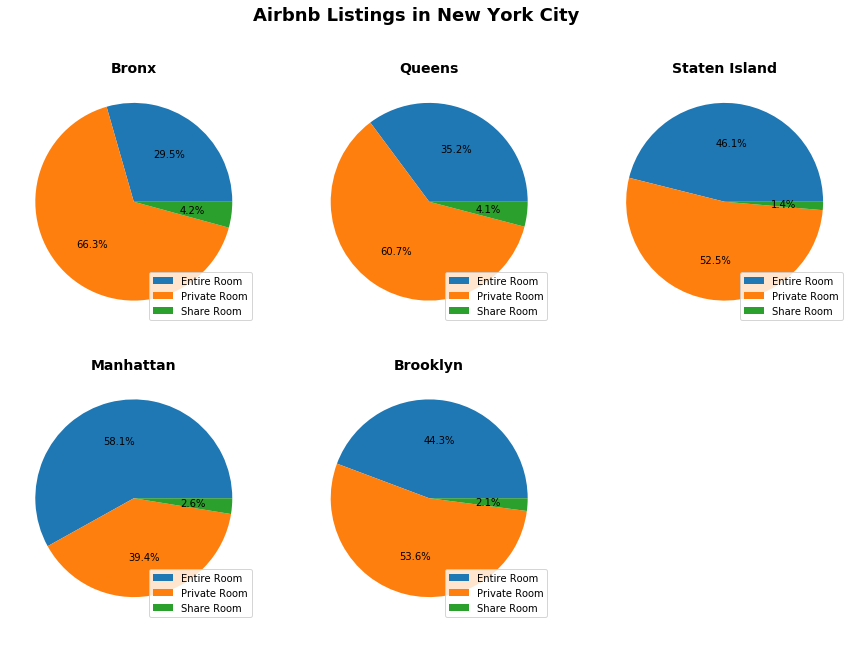

In [115]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))

fig.suptitle("Airbnb Listings in New York City", fontsize = 18, fontweight = "bold")

ax[0,0].pie(piechart("Bronx"), autopct='%1.1f%%')
ax[0,1].pie(piechart("Queens"), autopct='%1.1f%%')
ax[0,2].pie(piechart("Staten Island"), autopct='%1.1f%%')
ax[1,0].pie(piechart("Manhattan"), autopct='%1.1f%%')
ax[1,1].pie(piechart("Brooklyn"), autopct='%1.1f%%')
ax[1,2].axis('off')

ax[0,0].legend(["Entire Room", "Private Room", "Share Room"], loc = "lower right")
ax[0,1].legend(["Entire Room", "Private Room", "Share Room"], loc = "lower right")
ax[0,2].legend(["Entire Room", "Private Room", "Share Room"], loc = "lower right")
ax[1,0].legend(["Entire Room", "Private Room", "Share Room"], loc = "lower right")
ax[1,1].legend(["Entire Room", "Private Room", "Share Room"], loc = "lower right")

ax[0,0].set_title("Bronx", fontsize = 14, fontweight = "bold")
ax[0,1].set_title("Queens", fontsize = 14, fontweight = "bold")
ax[0,2].set_title("Staten Island", fontsize = 14, fontweight = "bold")
ax[1,0].set_title("Manhattan", fontsize = 14, fontweight = "bold")
ax[1,1].set_title("Brooklyn", fontsize = 14, fontweight = "bold")

The graph above shows that Bronx and Queens share roughly the same pattern, with around two thirds of private room, one third of entire room and minimal amount of share room. This is compliance with our intution, as Airbnb's core value is help people utilize spare rooms more efficiently. In these two boroughs, the room type pattern seems match up with the sharing-economy principle Airbnb is founded upon. Noticeably, both have the highest proportion of share room listings across five boroughs, at slighlty above 4%. While this is still at a minimal amount, it to some extent demonstrates that people choosing to reside in these to boroughs care less about privary and are probably more sensitive to prices and thus willing to share the room. 

Manhattan, on the other hand, has a much larger proportion of entire room listings, at around 60%. This is mostly likely to due the fact that Airbnb is one of popular means for college students and young white collars to get medium to long term housing. This is especially true for exchange students or international employees on rotation. With limited time in New York, Airbnb, which comes with furniture and rentals on the lower bound, is rather viable option. As Manhattan is home to headquarters of a large amount of multinational corporations and large research universities, including NYU, Columbia University and CUNY, it is understandable why there is larger portion of indenpendent apartments. On the other hand, this could also simply means that housing are smaller in general in Manhattan due to higher cost of living and more studios suitable for single residence are in this Borough. 

Lastly, Brooklyn and Staten Island, despite their huge disparity in population and number of listings, nevertheless have similar compositions of room types. Both of them are in the middle of the spectrum, with higher ratio of independent apartment listing to private room listing than Queens and Bronx. 

### What are the neighbourhoods have the most listings in each borough? ####

Admittedly, there is still a big variance within each borough. It would be interesting to figure out which neighbourhoods host the most Airbnb listings in each borough. 

In [116]:
ablist_ng = ablist.groupby(["Neighbourhood_group"])

def tophood(borough):
    borough = ablist_ng.get_group(borough)
    borough = borough.groupby(["Neighbourhood"])["Id"].count()
    borough = pd.DataFrame(borough)
    borough.columns = ["#Listing"]
    borough = borough.sort_values(by = "#Listing", ascending = False)
    return borough.head()

The function above returns the top five neighbourhoods that have the most Airbnb listings within the specified borough. Below, through a for loop, I am able to quickly display the situations in five boroughs altogether. 

In [117]:
nycborough = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]
for bor in nycborough:
    top_neighbourhoods = tophood(bor)
    print(bor)
    print(top_neighbourhoods)
    print("\n")

Bronx
               #Listing
Neighbourhood          
Kingsbridge          57
Concourse            56
Mott Haven           55
Parkchester          46
Longwood             40


Brooklyn
                    #Listing
Neighbourhood               
Williamsburg            4321
Bedford-Stuyvesant      3565
Bushwick                2484
Crown Heights           1687
Greenpoint              1151


Manhattan
                 #Listing
Neighbourhood            
Harlem               2883
East Village         2093
Upper West Side      2035
Hell's Kitchen       1868
Upper East Side      1782


Queens
                  #Listing
Neighbourhood             
Astoria                940
Long Island City       521
Flushing               386
Ridgewood              383
Ditmars Steinway       330


Staten Island
               #Listing
Neighbourhood          
St. George           51
Stapleton            25
Tompkinsville        25
Arrochar             17
Randall Manor        16




### Which neighbourhoods in New York City have the most listings? 

As a spin-off of the question above, it would also be insightful to figure out which neighbourhoods have the most abundant Airbnb supply across the entire city.

In [118]:
ablist_n = ablist.groupby(["Neighbourhood_group", "Neighbourhood"])["Id"].count()
ablist_n = pd.DataFrame(ablist_n)
ablist_n.columns = ["Listing"] 
ablist_n = ablist_n.sort_values(by = "Listing", ascending = False)
ablist_n.head(10)

Listing
Neighbourhood_group Neighbourhood              
Brooklyn            Williamsburg           4321
                    Bedford-Stuyvesant     3565
Manhattan           Harlem                 2883
Brooklyn            Bushwick               2484
Manhattan           East Village           2093
                    Upper West Side        2035
                    Hell's Kitchen         1868
                    Upper East Side        1782
Brooklyn            Crown Heights          1687
Manhattan           Midtown                1277

Not surprisingly, all of the top ten neighbourhoods are in Brooklyn (4) and Manhattan(6). The fact that tourists are frequent Williamsburg and Bushwick due to interesting sites and relatively cheap accommodation could partially explain why these two neighbourhoods are top on the list - supply has been pushed up by a steady demand.  

It is nevertheless surprising to see Harlem to top Manhattan's list. This is likely due to fact that it is more residential compared to the rest of the neighbourhoods in Manhattan. 

### Listing Density Map

Lastly, to map each lisitng as an individual point on New York City's map, I utilize geopandas and merge longitude and latitude information of the listing on neighbourhood tabulation area shape file found online. 

In [119]:
geometry = [Point(xy) for xy in zip(abloc.Longitude, abloc.Latitude)]

In [120]:
crs = {'init': 'epsg:4326'}
abnyc = gpd.GeoDataFrame(ablist, crs=crs, geometry=geometry)

**I attempted to read in the file through url, but failed so. Please refer to the shape file I have uploaded on my githuf to proceed with the next step.** 

In [121]:
regions_shape = "/Users/Nanji/Desktop/School Work/2018 Spring/Data_Bootcamp/Neighborhood Tabulation Areas"
coord_system = {'init': 'epsp:4326'}
nyc_map = gpd.read_file(regions_shape)

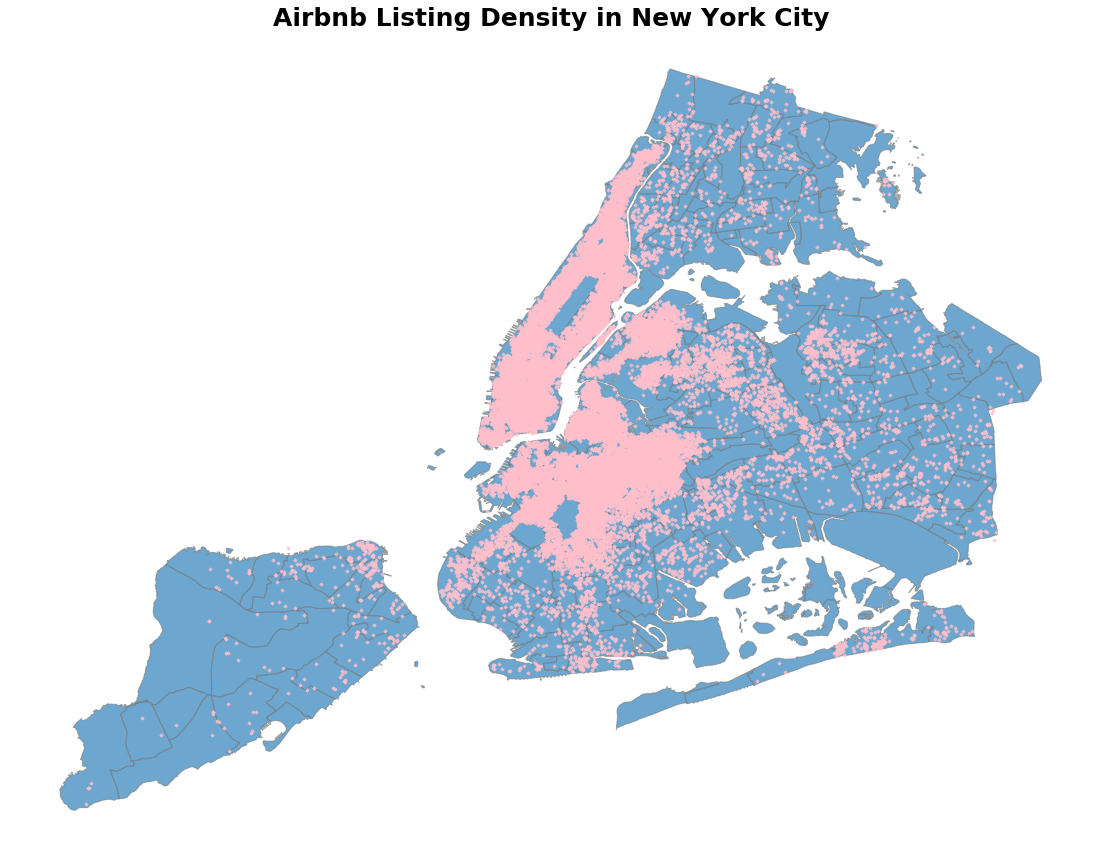

In [122]:
fig, ax = plt.subplots(figsize = (20,15))

ax.set_title("Airbnb Listing Density in New York City", fontweight = "bold", fontsize = 25)
ax.set_aspect('equal')
nyc_map.plot(ax = ax, edgecolor='tab:grey', alpha = 0.65) 
abnyc.plot(ax=ax, marker='D', color='pink', markersize=5, alpha = 0.75)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False) 
ax.spines["top"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["right"].set_visible(False) 

In line with my earlier analyses, Manhattan exhibits the densest listings, with almost every inch, except for Central Park, covered with listings. Tightly following after is Brooklyn. Noticably, neighbourhoods in Brooklyn that are closer to Manhattan exhibit denser listings. This rule is applicable for the rest of three boroughs too. In particular, listings in Staten Island and Bronx are concentrated at the side facing Manhattan. 

## Price Level Analysis ###

On another dimension, pricing of airbnb listings in New York City is also worth studying. Afterall, prices is one of the most important factors tourists and renters would take into account when booking Airbnb online. 

### Median Price in Each Borough ####

avgbprice = round(ablist_ng["Price"].agg("mean"), 2)
pd.DataFrame(avgbprice).sort_values(by = "Price", ascending = False)

Not surprisingly, Manhattan topped the list of average listing price, whereas Bronx is the most affordable borough. Unexpectedly, Staten Island is the second most expensive borough for Airbnb listings. This, however, should be considerd along with the fact that the number of listings in State Island is quite small and thus the average price is more susceptible to outliers. Below, I change the comparing metric to **median** to get a better sense of overall pricing standard in each borough. Notice that under this change, Brooklyn surpassed Staten Island as the second most expensive borough for Airbnb listings. 

In [123]:
avgbprice = round(ablist_ng["Price"].agg("median"), 2)
pd.DataFrame(avgbprice).sort_values(by = "Price", ascending = False)

,Price
Neighbourhood_group,
Manhattan,139
Brooklyn,89
Staten Island,75
Queens,71
Bronx,65


Below I visualize this data frame into a bar chart. 

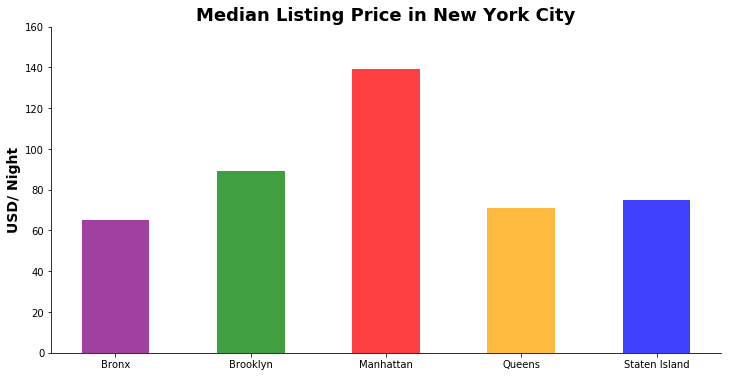

In [124]:
fig, ax = plt.subplots(figsize = (12,6))

ax.bar(avgbprice.index.tolist(), avgbprice, color = my_colors, width = 0.5, alpha = 0.75)

ax.set_title("Median Listing Price in New York City", fontsize = 18, fontweight = "bold")
ax.set_ylabel("USD/ Night", fontsize = 14, fontweight = "bold")

ax.set_ylim(0,160)

ax.spines["right"].set_visible(False) 
ax.spines["top"].set_visible(False) 

### Median Price by Each Room Type ####

To account for the fact that living experiences in three different types of rooms are quite distinct, I will break down median prices in each borough by room type in my next step of analysis.

In [125]:
ablist_ngrt = ablist.groupby(["Neighbourhood_group", "Room_type"])
mdnprice = round(ablist_ngrt["Price"].agg("median"), 2)
mdnprice = pd.DataFrame(mdnprice)
mdnprice.columns = ["Median_price"]
mdnprice

Median_price
Neighbourhood_group Room_type                    
Bronx               Entire home/apt          99.0
                    Private room             50.0
                    Shared room              46.0
Brooklyn            Entire home/apt         141.5
                    Private room             62.5
                    Shared room              36.0
Manhattan           Entire home/apt         189.0
                    Private room             85.0
                    Shared room              65.0
Queens              Entire home/apt         119.0
                    Private room             59.0
                    Shared room              36.5
Staten Island       Entire home/apt         110.0
                    Private room             50.0
                    Shared room              37.5

To visualize the above dataframe in a compound bar chart, I first convert it into a pivot table as follows:

In [126]:
mdnprice = mdnprice.pivot_table(index='Neighbourhood_group', 
                                columns='Room_type', 
                                values='Median_price')
mdnprice

Room_type,Entire home/apt,Private room,Shared room
Neighbourhood_group,,,
Bronx,99.0,50.0,46.0
Brooklyn,141.5,62.5,36.0
Manhattan,189.0,85.0,65.0
Queens,119.0,59.0,36.5
Staten Island,110.0,50.0,37.5


Text(0.5,1,'Breakdown by Room Type')

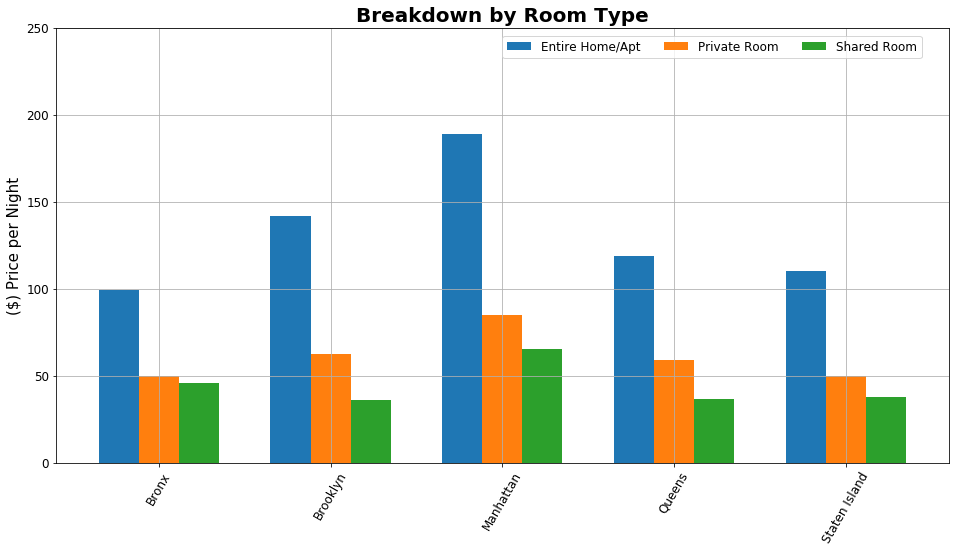

In [127]:
breakdown = mdnprice.plot.bar(figsize = (16, 8), grid = True,
                              ylim = (0,250), fontsize = 12, rot = 60, width = 0.7 )

breakdown.legend(["Entire Home/Apt","Private Room","Shared Room"], loc = [0.5,0.93], ncol=3, fontsize = 12)

breakdown.set_xlabel("")
breakdown.set_ylabel("($) Price per Night", fontsize = 15)

breakdown.set_title("Breakdown by Room Type", fontsize = 20, fontweight = "bold")

As shown in the graph above, all boroughs share the same pattern, with the entire home/apartment as the most expensive option, followed by private room and then shared room. This matches with our intution, as entire home/apartment gives renters more freedom, without the need to share common space with either the home owner or other renters.

Across the boroughs, in line with my earlier analyses, Manhattan is home to the highest rentals in each room type, followed by Brooklyn. Noticeably, however, there is not much difference between the other three boroughs, Bronx, Queens and Staten Island. 

With this graph, we can easily conclude that overall, the most expensive combination of borough and room type is renting an entire home or apartment in Manhattan, whereas the cheapest option is to rent a shared room in either Brooklyn or Queens. The two options roughly have four times differences. 

### Average Price in Each Neighbourhood ####

Lastly, in this section, it would be insightful to figure out the average price across each neighbourhood and show the most expensive areas and cheapest areas.

In [128]:
ablist_n = pd.DataFrame(ablist.groupby(["Neighbourhood"]).count())
neighbourhood = ablist_n.index.tolist()
new_dic = {"":""}
for var in neighbourhood:
    neighbourhood = ablist[ablist["Neighbourhood"] == var] 
    avg = round(neighbourhood["Price"].mean(), 2)
    dic = {var:avg}
    new_dic.update(dic)

nhood_avgprice = pd.DataFrame(list(new_dic.items()), columns = ["Neighbourhood", "Average_price ($)"])

The coding is slightly more complicated compared with the listing section, since I cannot simply get away with the count methods. Below, with the aid of a for loop, I extracted a sub-dataframe made up of all listings under each neighbourhood separately. I then calculated the mean of the prices for each sub-dataframe. 

Next, I turned congregated all information under a dictionary. Under each loop, I set the neighbourhood name as the dictionary key and the average price calculated as the dictionary value. With the help of a blank dictionary - similar to the function of a counter - set up before the for loop, I am able to append every new dictionary generated from the for loop through method update. 

In [129]:
nhood_avgprice["Average_price ($)"] = pd.to_numeric(nhood_avgprice["Average_price ($)"])
nhood_avgprice = nhood_avgprice.sort_values(by = "Average_price ($)", ascending = False)

In [130]:
nhood_avgprice.set_index("Neighbourhood").head(20)

,Average_price ($)
Neighbourhood,
Fort Wadsworth,800.00
Westerleigh,547.67
Lighthouse Hill,496.67
Woodrow,462.50
Tribeca,395.37
Riverdale,391.06
Randall Manor,387.88
Flatiron District,323.37
Sea Gate,314.38


In [131]:
nhood_avgprice = nhood_avgprice.sort_values(by = "Average_price ($)", ascending = False)
nhood_avgprice.set_index("Neighbourhood").tail(20)

,Average_price ($)
Neighbourhood,
Woodlawn,60.71
Bronxdale,60.31
Grant City,60.00
Morris Heights,59.00
Belmont,58.42
Edenwald,57.89
Claremont Village,54.59
Tremont,52.18
Little Neck,51.50


## Closing Thoughts

This report shows that New York City has abundant Airbnb listings that scatter across almost all neighbourhoods. They roughly share the same breakdown and pricing pattern by room type, while differences across individual neighbourhoods are still quite big. These insights, on the other hand, beg the question of "How do these massive amount of Airbn listings compare with alternative living environment, i.e. hotels and leasing apartments?" 

This is the next question I would love to solve through the section below. My current plan is to first clean up the Airbnb dataset on hand (mostly to convert longtitude and latitude into zipcodes for heat map mapping purposes) and then extract hotel information from Yelp' API. Specifically, every hotel listed on Yelp indicates price level through number of dollar signs "$". Converting them into number will allow us to graph them on a heat map and compare with Airbnb prices.

## (Ongoing Section: Continue after Grading; Below are Current Progress) 
## Price Level Comparison

### Zipcode Conversion 

As the Airbnb dataset does not come with zip code information, it makes the creation of a heat map based on price levels across neighbourhoods difficult. To achieve this, I will utilize a new library, geocoder, to convert longtitude and latitude information into zip codes, which are more mapping-friendly. 

In [132]:
import geocoder

In [133]:
abloc_new = abloc.set_index("Id")
ablocdict = abloc_new.to_dict()

In [134]:
ID = pd.to_numeric(abloc["Id"])
ID = abloc["Id"].tolist()

The function below returns zipcode after inputting ID of each listing. 

In [135]:
def zipcode(Id):
    lat = ablocdict["Latitude"].pop(Id)
    log = ablocdict["Longitude"].pop(Id)
    return geocoder.google([lat, log], method='reverse').postal

Using a for loop, I will be able to convert all listings' longitude and latitude information into zip codes. 

In [ ]:
new_dic = {"":""}
for var in ID:
    g = zipcode(var)
    dic = {var:g}
    new_dic.update(dic)

### Introduce Yelp API#### 
Below I use the Yelp API to grab price levels denoted by "$" for hotels all across New York  

In [ ]:
import argparse
import json
import pprint
import requests
import sys
import urllib

try:
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode

API key can be easily obtained on Yelp's website. 

In [ ]:
api_key = "V9KIR9KSlZgIunfSgwFNUY6DW1GBr-MJrwQJepeswI0ASq3koN6eWgijk2KywRxwbrecey"
API_KEY = api_key + "7O39IFr1DXXz-FnLjA844Wb99UKL4dh7XbCeWRiGUg_y2SOb1gyJ7mWnYx"

Below are sample codes from Yelp's website that serves to help people make inquiries using their API.

In [ ]:
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  

In [ ]:
def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()

In [ ]:
def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)

In [ ]:
def search(api_key, term, location, offset):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': 50,
        "offset": offset
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)

In [ ]:
def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)

Passing on "Hotels" and "New York", allows me to grab information on NYC hotel listings on Yelp. 

In [ ]:
r = search(API_KEY, "Hotels", "New York", 1)

In [ ]:
test = pd.DataFrame(r["businesses"])

In [ ]:
test